# Imports #

We begin by importing several Python packages.

In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

In [ ]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

# Step 2: Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model.

In [ ]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different *replicas* of the model, one for each core.

# Step 3: Loading the Competition Data #

## Get GCS Path ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [ ]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).

## Load Data ##

When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 
AUTO = tf.data.experimental.AUTOTUNE
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


# Explore Data #

Let's take a moment to look at some of the images in the dataset.

In [ ]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Transform the Data

In [ ]:
def decode_image(image_data,image_size):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*image_size, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example, image_size):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], image_size)
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example, image_size):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], image_size)
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, image_size, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda x: read_labeled_tfrecord(x, image_size) if labeled else read_unlabeled_tfrecord(x, image_size), num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

# Augmentation of Data

In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset(train_file_name, image_size):
    dataset = load_dataset(train_file_name, image_size, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(validation_file_name, image_size,ordered=False):
    dataset = load_dataset(validation_file_name, image_size, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(test_file_name,image_size,ordered=False):
    dataset = load_dataset(test_file_name,image_size, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Learning Rate

In [ ]:
EPOCHS = 10
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model - VGG 16 PRETRAINED MODEL

In [ ]:
with strategy.scope():
    def create_vgg16_model(input_shape, N_CLASSES):
        pretrained_model = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
        pretrained_model.trainable = True

        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(N_CLASSES, activation='softmax')
        ])

        return model
def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

def fine_tuning_lr(epoch, base_lr=0.00001, multiplier=0.2):
    return base_lr * (multiplier ** epoch)

# Example usage:
initial_fine_tuning_lr = fine_tuning_lr(0)

# MODEL VGG - 19 PRETRAINED MODEL

In [ ]:
with strategy.scope():
    def create_vgg19_model(input_shape, N_CLASSES):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
        pretrained_model.trainable = True

        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(N_CLASSES, activation='softmax')
        ])

        return model
def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

def fine_tuning_lr(epoch, base_lr=0.00001, multiplier=0.2):
    return base_lr * (multiplier ** epoch)

# Example usage:
initial_fine_tuning_lr = fine_tuning_lr(0)

# CUSTOM ARCHITECTURE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional and pooling layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Optional dropout layer for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )


def fine_tuning_lr(epoch, base_lr=0.00001, multiplier=0.2):
    return base_lr * (multiplier ** epoch)
initial_fine_tuning_lr = fine_tuning_lr(0)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import time
import matplotlib.pyplot as plt

def create_custom_model(input_shape, num_classes, num_neurons_list, num_layers, conv_shape):
    model = models.Sequential()
    
    # Convolutional Layer
    model.add(layers.Conv2D(32, conv_shape, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and dense layers
    model.add(layers.Flatten())

    for _ in range(num_layers):
        for neurons in num_neurons_list:
            model.add(layers.Dense(neurons, activation='relu'))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

def fine_tuning_lr(epoch, base_lr=0.00001, multiplier=0.2):
    return base_lr * (multiplier ** epoch)


# CUSTOM ARCHITECTURE FOR VGG 19

### Fine Tuning the Dense Layers with Batch Normalization to Accelerate the training process

In [ ]:
def customize_vgg19_model(input_shape, N_CLASSES):
    pretrained_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ])

    return model

def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

def fine_tuning_lr(epoch, base_lr=0.00001, multiplier=0.2):
    return base_lr * (multiplier ** epoch)
initial_fine_tuning_lr = fine_tuning_lr(0)

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Confusion Matrix

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [ ]:
def generate_confusion_matrix(model, validation_dataset, number_validation_images):
    images_ds = validation_dataset.map(lambda image, label: image)
    labels_ds = validation_dataset.map(lambda image, label: label).unbatch()

    correct_labels = next(iter(labels_ds.batch(number_validation_images))).numpy()
    probabilities = model.predict(images_ds)
    predictions = np.argmax(probabilities, axis=-1)

    labels = range(len(CLASSES))
    cmat = confusion_matrix(correct_labels, predictions, labels=labels)
    cmat = (cmat.T / cmat.sum(axis=1)).T  # normalize
    
    f1 = f1_score(correct_labels, predictions, labels=labels, average='macro')
    precision = precision_score(correct_labels, predictions, labels=labels, average='macro')
    recall = recall_score(correct_labels, predictions, labels=labels, average='macro')

    display_confusion_matrix(cmat, f1, precision, recall)

In [ ]:
def compute_predictions(model, dataset):
    images_ds = dataset.map(lambda image, idnum: image)
    probabilities = model.predict(images_ds)
    predictions = np.argmax(probabilities, axis=-1)
    return predictions

def generate_submission(model, test_dataset, output_filename, number_test_images):
    predictions = compute_predictions(model, test_dataset)
    test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(number_test_images))).numpy().astype('U')
    np.savetxt(
        output_filename,
        np.rec.fromarrays([test_ids, predictions]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='id,label',
        comments='',
    )

    print(f'Generated {output_filename} file successfully!')

# **RESOLUTION = 512 x 512**

In [ ]:
IMAGE_SIZE_512 = [512, 512]
GCS_PATH_512 = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

TRAINING_FILENAMES_512 = tf.io.gfile.glob(GCS_PATH_512 + '/train/*.tfrec')
VALIDATION_FILENAMES_512 = tf.io.gfile.glob(GCS_PATH_512 + '/val/*.tfrec')
TEST_FILENAMES_512 = tf.io.gfile.glob(GCS_PATH_512 + '/test/*.tfrec')                                                                                          # 100 - 10

In [ ]:
NUM_TRAINING_IMAGES_512 = count_data_items(TRAINING_FILENAMES_512)
NUM_VALIDATION_IMAGES_512 = count_data_items(VALIDATION_FILENAMES_512)
NUM_TEST_IMAGES_512 = count_data_items(TEST_FILENAMES_512)

print('Dataset - 512 x 512: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES_512, NUM_VALIDATION_IMAGES_512, NUM_TEST_IMAGES_512))

In [ ]:
ds_train_512 = get_training_dataset(TRAINING_FILENAMES_512, IMAGE_SIZE_512)
ds_valid_512 = get_validation_dataset(VALIDATION_FILENAMES_512, IMAGE_SIZE_512)
ds_test_512 = get_test_dataset(TEST_FILENAMES_512, IMAGE_SIZE_512)

print("Training - 512:", ds_train_512)
print ("Validation - 512:", ds_valid_512)
print("Test - 512:", ds_test_512)

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training - 512 data shapes:")
for image, label in ds_train_512.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training - 512 data label examples:", label.numpy())

In [ ]:
print("Test - 512 data shapes:")
for image, idnum in ds_test_512.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test - 512 data IDs:", idnum.numpy().astype('U')) # U=unicode string

In [ ]:
ds_iter_512 = iter(ds_train_512.unbatch().batch(20))

In [ ]:
print("PRINTING ONE BATCH OF 512 x 512 SIZE IMAGES")
one_batch_512 = next(ds_iter_512)
display_batch_of_images(one_batch_512)

In [ ]:
lr_callback_512 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [ ]:
with strategy.scope():
    model_512 = create_vgg16_model(IMAGE_SIZE_512 + [3], len(CLASSES))


In [ ]:
optimizer_512 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)

In [ ]:
with strategy.scope():
    compile_model(model_512,optimizer_512)
    model_512.summary()

In [ ]:
STEPS_PER_EPOCH_512 = NUM_TRAINING_IMAGES_512 // BATCH_SIZE

In [ ]:
history_512 = model_512.fit(
    ds_train_512,
    validation_data=ds_valid_512,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_512,
    callbacks=[lr_callback_512],
)

In [ ]:
display_training_curves(
    history_512.history['loss'],
    history_512.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_512.history['sparse_categorical_accuracy'],
    history_512.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
confusion_matrix_512 = generate_confusion_matrix(model_512, get_validation_dataset(VALIDATION_FILENAMES_512, IMAGE_SIZE_512, ordered = True), NUM_VALIDATION_IMAGES_512)

In [ ]:
dataset_512 = get_validation_dataset(VALIDATION_FILENAMES_512, IMAGE_SIZE_512)
dataset_512 = dataset_512.unbatch().batch(20)
batch_512 = iter(dataset_512)

In [ ]:
images, labels = next(batch_512)
probabilities = model_512.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
test_ds_512 = get_test_dataset(TEST_FILENAMES_512, IMAGE_SIZE_512, ordered=True)

In [ ]:
# generate_submission(model_512, test_ds_512, 'submission.csv', NUM_TEST_IMAGES_512)

# **RESOLUTION = 331 x 331**

In [ ]:
IMAGE_SIZE_331 = [331, 331]
GCS_PATH_331 = GCS_DS_PATH + '/tfrecords-jpeg-331x331'

TRAINING_FILENAMES_331 = tf.io.gfile.glob(GCS_PATH_331 + '/train/*.tfrec')
VALIDATION_FILENAMES_331 = tf.io.gfile.glob(GCS_PATH_331 + '/val/*.tfrec')
TEST_FILENAMES_331 = tf.io.gfile.glob(GCS_PATH_331 + '/test/*.tfrec')

In [ ]:
NUM_TRAINING_IMAGES_331 = count_data_items(TRAINING_FILENAMES_331)
NUM_VALIDATION_IMAGES_331 = count_data_items(VALIDATION_FILENAMES_331)
NUM_TEST_IMAGES_331 = count_data_items(TEST_FILENAMES_331)

print('Dataset - 331 x 331: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES_331, NUM_VALIDATION_IMAGES_331, NUM_TEST_IMAGES_331))

In [ ]:
ds_train_331 = get_training_dataset(TRAINING_FILENAMES_331, IMAGE_SIZE_331)
ds_valid_331 = get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331)
ds_test_331 = get_test_dataset(TEST_FILENAMES_331, IMAGE_SIZE_331)

print("Training - 331:", ds_train_331)
print ("Validation - 331:", ds_valid_331)
print("Test - 331:", ds_test_331)

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training - 331 data shapes:")
for image, label in ds_train_331.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training - 331 data label examples:", label.numpy())

In [ ]:
print("Test - 331 data shapes:")
for image, idnum in ds_test_331.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test - 331 data IDs:", idnum.numpy().astype('U')) # U=unicode string

In [ ]:
ds_iter_331 = iter(ds_train_331.unbatch().batch(20))

In [ ]:
print("PRINTING ONE BATCH OF 331 x 331 SIZE IMAGES")
one_batch_331 = next(ds_iter_331)
display_batch_of_images(one_batch_331)

In [ ]:
lr_callback_331_vgg16 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
lr_callback_331_vgg19 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
lr_callback_331_custom_model = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
lr_callback_331_customize_vgg19 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [ ]:
num_neurons_list = [100, 200, 300]
num_layers = 3
conv_shape = (3, 3)

In [ ]:
with strategy.scope():
    model_331_vgg16 = create_vgg16_model(IMAGE_SIZE_331 + [3], len(CLASSES))
    model_331_vgg19 = create_vgg19_model(IMAGE_SIZE_331 + [3], len(CLASSES))
    model_331_custom_model = create_custom_model(IMAGE_SIZE_331 + [3], len(CLASSES), num_neurons_list,num_layers,conv_shape)
    model_331_customize_vgg19 = customize_vgg19_model(IMAGE_SIZE_331 + [3], len(CLASSES))

In [ ]:
optimizer_331_vgg16 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)
optimizer_331_vgg19 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)
optimizer_331_custom_model = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)
optimizer_331_customize_vgg19 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)

In [ ]:
from tensorflow.keras.utils import plot_model
with strategy.scope():
    compile_model(model_331_vgg16,optimizer_331_vgg16)
    plot_model(model_331_vgg16, to_file='model_331_vgg16.png', show_shapes=True, show_layer_names=True)
    model_331_vgg16.summary()
    compile_model(model_331_vgg19,optimizer_331_vgg19)
    plot_model(model_331_vgg19, to_file='model_331_vgg19.png', show_shapes=True, show_layer_names=True)
    model_331_vgg19.summary()
    compile_model(model_331_custom_model,optimizer_331_custom_model)
    plot_model(model_331_custom_model, to_file='model_331_custom_model.png', show_shapes=True, show_layer_names=True)
    model_331_custom_model.summary()
    compile_model(model_331_customize_vgg19,optimizer_331_customize_vgg19)
    plot_model(model_331_customize_vgg19, to_file='model_331_customize_vgg19.png', show_shapes=True, show_layer_names=True)
    model_331_customize_vgg19.summary()

In [ ]:
STEPS_PER_EPOCH_331 = NUM_TRAINING_IMAGES_331 // BATCH_SIZE

In [ ]:
history_331_vgg16 = model_331_vgg16.fit(
    ds_train_331,
    validation_data=ds_valid_331,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_331,
    callbacks=[lr_callback_331_vgg16],
)

In [ ]:
history_331_vgg19 = model_331_vgg19.fit(
    ds_train_331,
    validation_data=ds_valid_331,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_331,
    callbacks=[lr_callback_331_vgg19],
)

In [ ]:
history_331_custom_model = model_331_custom_model.fit(
    ds_train_331,
    validation_data=ds_valid_331,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_331,
    callbacks=[lr_callback_331_custom_model],
)

In [ ]:
history_331_customize_vgg19 = model_331_customize_vgg19.fit(
    ds_train_331,
    validation_data=ds_valid_331,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_331,
    callbacks=[lr_callback_331_customize_vgg19],
)

In [ ]:
display_training_curves(
    history_331_vgg16.history['loss'],
    history_331_vgg16.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_331_vgg16.history['sparse_categorical_accuracy'],
    history_331_vgg16.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
display_training_curves(
    history_331_vgg19.history['loss'],
    history_331_vgg19.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_331_vgg19.history['sparse_categorical_accuracy'],
    history_331_vgg19.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
display_training_curves(
    history_331_custom_model.history['loss'],
    history_331_custom_model.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_331_custom_model.history['sparse_categorical_accuracy'],
    history_331_custom_model.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
display_training_curves(
    history_331_customize_vgg19.history['loss'],
    history_331_customize_vgg19.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_331_customize_vgg19.history['sparse_categorical_accuracy'],
    history_331_customize_vgg19.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
confusion_matrix_331_vgg16 = generate_confusion_matrix(model_331_vgg16, get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331, ordered = True), NUM_VALIDATION_IMAGES_331)

In [ ]:
confusion_matrix_331_vgg19 = generate_confusion_matrix(model_331_vgg19, get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331, ordered = True), NUM_VALIDATION_IMAGES_331)

In [ ]:
confusion_matrix_331_custom_model = generate_confusion_matrix(model_331_custom_model, get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331, ordered = True), NUM_VALIDATION_IMAGES_331)

In [ ]:
confusion_matrix_331_customize_vgg19 = generate_confusion_matrix(model_331_customize_vgg19, get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331, ordered = True), NUM_VALIDATION_IMAGES_331)

In [ ]:
dataset_331 = get_validation_dataset(VALIDATION_FILENAMES_331, IMAGE_SIZE_331)
dataset_331 = dataset_331.unbatch().batch(20)
batch_331 = iter(dataset_331)

In [ ]:
images, labels = next(batch_331)
probabilities_vgg16 = model_331_vgg16.predict(images)
predictions = np.argmax(probabilities_vgg16, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
images, labels = next(batch_331)
probabilities_vgg19 = model_331_vgg19.predict(images)
predictions = np.argmax(probabilities_vgg19, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
images, labels = next(batch_331)
probabilities_custom_model = model_331_custom_model.predict(images)
predictions = np.argmax(probabilities_custom_model, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
images, labels = next(batch_331)
probabilities_customize_vgg19 = model_331_customize_vgg19.predict(images)
predictions = np.argmax(probabilities_customize_vgg19, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
test_ds_331 = get_test_dataset(TEST_FILENAMES_331, IMAGE_SIZE_331, ordered=True)

In [ ]:
# generate_submission(model_331_vgg16, test_ds_331, 'submission.csv', NUM_TEST_IMAGES_331)
generate_submission(model_331_vgg19, test_ds_331, 'submission.csv', NUM_TEST_IMAGES_331)
# generate_submission(model_331_custom_model, test_ds_331, 'submission.csv', NUM_TEST_IMAGES_331)
# generate_submission(model_331_customize_vgg19, test_ds_331, 'submission.csv', NUM_TEST_IMAGES_331)

# **RESOLUTION = 224 x 224**

In [ ]:
IMAGE_SIZE_224 = [224, 224]
GCS_PATH_224 = GCS_DS_PATH + '/tfrecords-jpeg-224x224'

TRAINING_FILENAMES_224 = tf.io.gfile.glob(GCS_PATH_224 + '/train/*.tfrec')
VALIDATION_FILENAMES_224 = tf.io.gfile.glob(GCS_PATH_224 + '/val/*.tfrec')
TEST_FILENAMES_224 = tf.io.gfile.glob(GCS_PATH_224 + '/test/*.tfrec')

In [ ]:
NUM_TRAINING_IMAGES_224 = count_data_items(TRAINING_FILENAMES_224)
NUM_VALIDATION_IMAGES_224 = count_data_items(VALIDATION_FILENAMES_224)
NUM_TEST_IMAGES_224 = count_data_items(TEST_FILENAMES_224)

print('Dataset - 224 x 224: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES_224, NUM_VALIDATION_IMAGES_224, NUM_TEST_IMAGES_224))

In [ ]:
ds_train_224 = get_training_dataset(TRAINING_FILENAMES_224, IMAGE_SIZE_224)
ds_valid_224 = get_validation_dataset(VALIDATION_FILENAMES_224, IMAGE_SIZE_224)
ds_test_224 = get_test_dataset(TEST_FILENAMES_224, IMAGE_SIZE_224)

print("Training - 224:", ds_train_224)
print ("Validation - 224:", ds_valid_224)
print("Test - 224:", ds_test_224)

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training - 224 data shapes:")
for image, label in ds_train_224.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training - 224 data label examples:", label.numpy())

In [ ]:
print("Test - 224 data shapes:")
for image, idnum in ds_test_224.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test - 224 data IDs:", idnum.numpy().astype('U')) # U=unicode string

In [ ]:
ds_iter_224 = iter(ds_train_224.unbatch().batch(20))

In [ ]:
print("PRINTING ONE BATCH OF 224 x 224 SIZE IMAGES")
one_batch_224 = next(ds_iter_224)
display_batch_of_images(one_batch_224)

In [ ]:
lr_callback_224 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [ ]:
with strategy.scope():
    model_224 = create_vgg16_model(IMAGE_SIZE_224 + [3], len(CLASSES))


In [ ]:
optimizer_224 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)

In [ ]:
with strategy.scope():
    compile_model(model_224,optimizer_224)
    model_224.summary()

In [ ]:
STEPS_PER_EPOCH_224 = NUM_TRAINING_IMAGES_224 // BATCH_SIZE

In [ ]:
history_224 = model_224.fit(
    ds_train_224,
    validation_data=ds_valid_224,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_224,
    callbacks=[lr_callback_224],
)

In [ ]:
display_training_curves(
    history_224.history['loss'],
    history_224.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_224.history['sparse_categorical_accuracy'],
    history_224.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
confusion_matrix_224 = generate_confusion_matrix(model_224, get_validation_dataset(VALIDATION_FILENAMES_224, IMAGE_SIZE_224, ordered = True), NUM_VALIDATION_IMAGES_224)

In [ ]:
dataset_224 = get_validation_dataset(VALIDATION_FILENAMES_224, IMAGE_SIZE_224)
dataset_224 = dataset_224.unbatch().batch(20)
batch_224 = iter(dataset_224)

In [ ]:
images, labels = next(batch_224)
probabilities = model_224.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
test_ds_224 = get_test_dataset(TEST_FILENAMES_224, IMAGE_SIZE_224, ordered=True)

In [ ]:
# generate_submission(model_224, test_ds_224, 'submission.csv', NUM_TEST_IMAGES_224)

# **RESOLUTION = 192 x 192**

In [ ]:
IMAGE_SIZE_192 = [192, 192]
GCS_PATH_192 = GCS_DS_PATH + '/tfrecords-jpeg-192x192'

TRAINING_FILENAMES_192 = tf.io.gfile.glob(GCS_PATH_192 + '/train/*.tfrec')
VALIDATION_FILENAMES_192 = tf.io.gfile.glob(GCS_PATH_192 + '/val/*.tfrec')
TEST_FILENAMES_192 = tf.io.gfile.glob(GCS_PATH_192 + '/test/*.tfrec')

In [ ]:
NUM_TRAINING_IMAGES_192 = count_data_items(TRAINING_FILENAMES_192)
NUM_VALIDATION_IMAGES_192 = count_data_items(VALIDATION_FILENAMES_192)
NUM_TEST_IMAGES_192 = count_data_items(TEST_FILENAMES_192)

print('Dataset - 224 x 224: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES_192, NUM_VALIDATION_IMAGES_192, NUM_TEST_IMAGES_192))

In [ ]:
ds_train_192 = get_training_dataset(TRAINING_FILENAMES_192, IMAGE_SIZE_192)
ds_valid_192 = get_validation_dataset(VALIDATION_FILENAMES_192, IMAGE_SIZE_192)
ds_test_192 = get_test_dataset(TEST_FILENAMES_192, IMAGE_SIZE_192)

print("Training - 192:", ds_train_192)
print ("Validation - 192:", ds_valid_192)
print("Test - 192:", ds_test_192)

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training - 192 data shapes:")
for image, label in ds_train_192.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training - 192 data label examples:", label.numpy())

In [ ]:
print("Test - 192 data shapes:")
for image, idnum in ds_test_192.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test - 192 data IDs:", idnum.numpy().astype('U')) # U=unicode string

In [ ]:
ds_iter_192 = iter(ds_train_192.unbatch().batch(20))

In [ ]:
print("PRINTING ONE BATCH OF 192 x 192 SIZE IMAGES")
one_batch_192 = next(ds_iter_192)
display_batch_of_images(one_batch_192)

In [ ]:
lr_callback_192 = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [ ]:
with strategy.scope():
    model_192 = create_vgg16_model(IMAGE_SIZE_192 + [3], len(CLASSES))


In [ ]:
optimizer_192 = tf.keras.optimizers.Adam(learning_rate=initial_fine_tuning_lr)

In [ ]:
with strategy.scope():
    compile_model(model_192,optimizer_192)
    model_192.summary()

In [ ]:
STEPS_PER_EPOCH_192 = NUM_TRAINING_IMAGES_192 // BATCH_SIZE

In [ ]:
history_192 = model_192.fit(
    ds_train_192,
    validation_data=ds_valid_192,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_192,
    callbacks=[lr_callback_192],
)


In [ ]:
display_training_curves(
    history_192.history['loss'],
    history_192.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history_192.history['sparse_categorical_accuracy'],
    history_192.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
confusion_matrix_192 = generate_confusion_matrix(model_192, get_validation_dataset(VALIDATION_FILENAMES_192, IMAGE_SIZE_192, ordered = True), NUM_VALIDATION_IMAGES_192)


In [ ]:
dataset_192 = get_validation_dataset(VALIDATION_FILENAMES_192, IMAGE_SIZE_192)
dataset_192 = dataset_192.unbatch().batch(20)
batch_192 = iter(dataset_192)

In [ ]:
images, labels = next(batch_192)
probabilities = model_192.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
test_ds_192 = get_test_dataset(TEST_FILENAMES_192, IMAGE_SIZE_192, ordered=True)

In [ ]:
# generate_submission(model_192, test_ds_192, 'submission.csv', NUM_TEST_IMAGES_192)

# COMPARING THE MODELS BASED ON ACCURACY

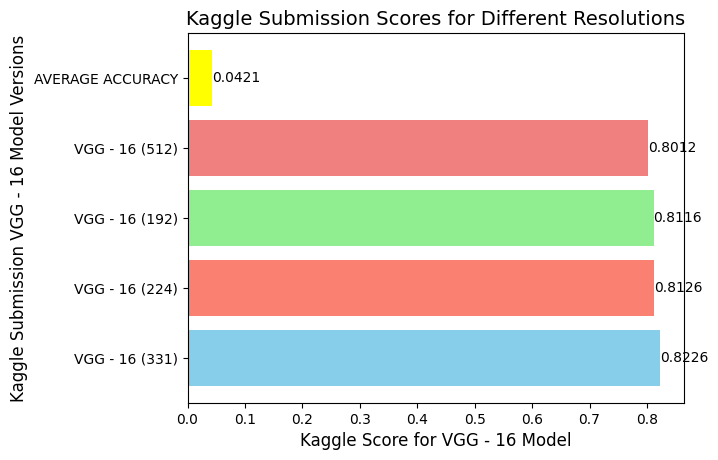

In [10]:
import matplotlib.pyplot as plt
# Submission data
versions = ['VGG - 16 (331)', 'VGG - 16 (224)', 'VGG - 16 (192)', 'VGG - 16 (512)', 'AVERAGE ACCURACY']
# Corresponding Kaggle scores
scores = [0.82255, 0.81265, 0.8116, 0.80122, 0.04212]
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'yellow']
# Create a horizontal bar chart with different colors and additional styling
fig, ax = plt.subplots()
bars = ax.barh(versions, scores, color=colors)
for bar, score in zip(bars, scores):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{score:.4f}', ha='left', va='center')
ax.set_xlabel('Kaggle Score for VGG - 16 Model', fontsize=12)
ax.set_ylabel('Kaggle Submission VGG - 16 Model Versions', fontsize=12)
ax.set_title('Kaggle Submission Scores for Different Resolutions', fontsize=14)
plt.show()


# VGG - 16 Model for Resolution 331 x 331 gave better accuracy comparitvely to other resolutions

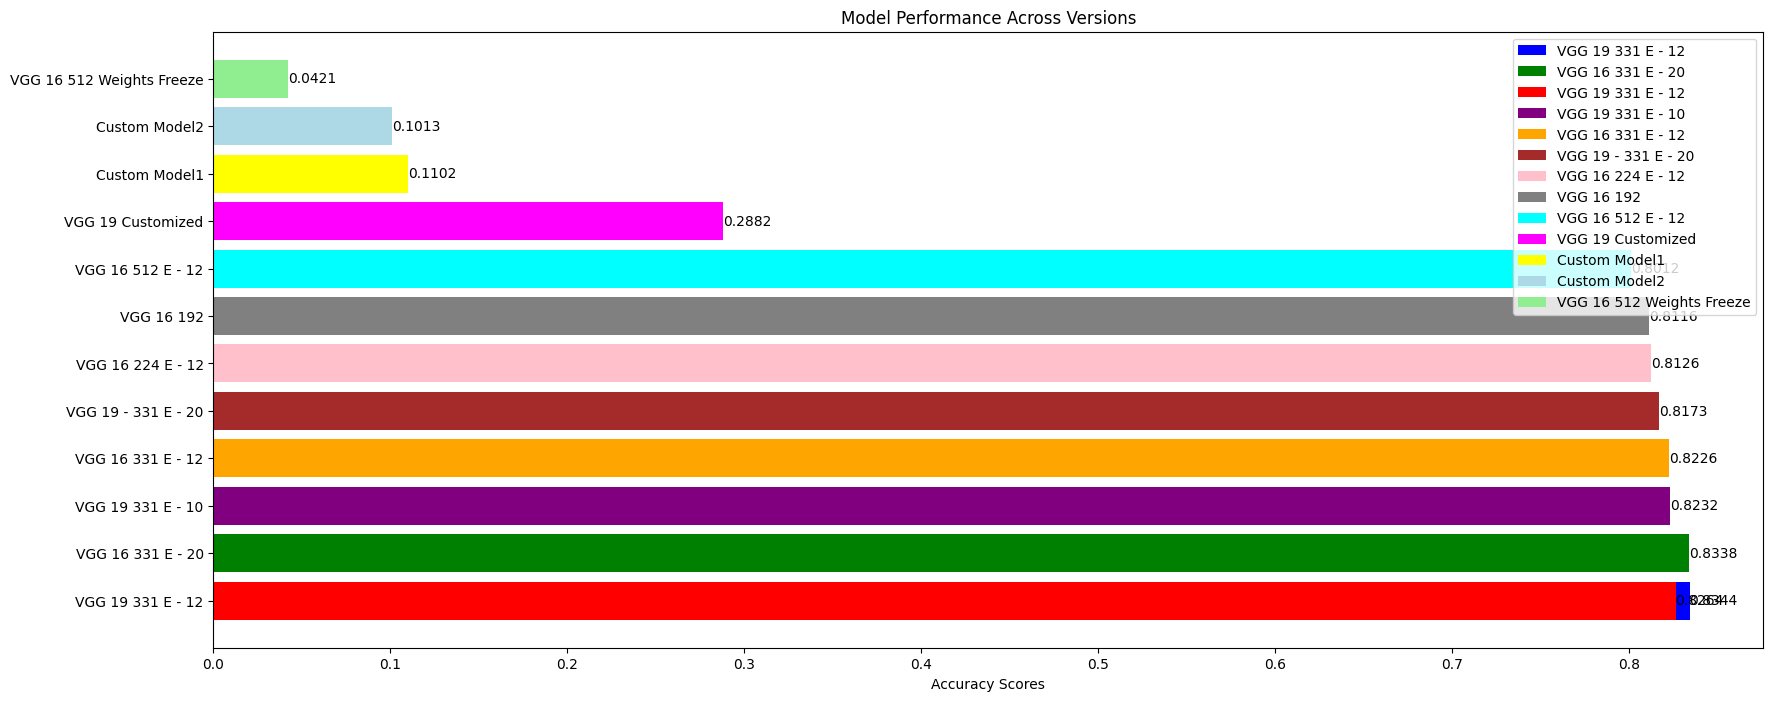

In [11]:
import matplotlib.pyplot as plt
import numpy as np

versions = ["VGG 19 331 E - 12", "VGG 16 331 E - 20", "VGG 19 331 E - 12", "VGG 19 331 E - 10", "VGG 16 331 E - 12", "VGG 19 - 331 E - 20", "VGG 16 224 E - 12", "VGG 16 192", "VGG 16 512 E - 12", "VGG 19 Customized", "Custom Model1", "Custom Model2", "VGG 16 512 Weights Freeze"]
accuracy_scores = [0.83435, 0.83384, 0.82643, 0.82322, 0.82255, 0.81733, 0.81265, 0.8116, 0.80122, 0.28821, 0.11022, 0.10125, 0.04212]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'lightblue', 'lightgreen']

plt.figure(figsize=(20, 8))
bars = plt.barh(versions, accuracy_scores, color=colors)
plt.xlabel('Accuracy Scores')
plt.title('Model Performance Across Versions')
legend_labels = versions
plt.legend(bars, legend_labels, loc='upper right')
for bar, score in zip(bars, accuracy_scores):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{score:.4f}', ha='left', va='center')
plt.show()
